In [94]:
library(tidyverse)
library(repr)
library(readxl)
library(tidymodels)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

# KNN Classification of Player Subscription Patterns

## Introduction
At UBC a computer science research team directed by Frank Wood is collecting data about how people play video games.The data is going to be used to train autoregressive diffusion models, in an attempt to create a model that learns continuously. They investigated this by creating a minecraft server to begin tracking and recording the movements and actions of players. To run this research they have to make sure they efficiently collect and record players to obtain enough data whilst still having enough resources to run the project, such as software licenses. To help with their research they are looking to see who subscribes to the newsletter as there are stakeholders that may want to know what demographic applies to the newsletter. 


To find out who is most likely to subscribe, we are going to create a model that predicts if the player will **subscribe** to the playing newsletter depending on the **playing hours** and **age** of the players. To do this we will target and tidy data relevant to the question. 


The data set used contains seven variables as a description of the player. This includes experience, subscribe, hashed email, played_hours, name, gender, age. The variables age and played_hours are numeric variables; subscribe is logical variable; and experience, name, and gender are are characters. The data will then be wrangled and organised clearly to be used in the model. The model will consist of a knn class prediction based upon the variables of playing hour and age of the players. Ultimately we aim to build a prediction model will produce data that will aid the UBC computer science research team in their research. 

## Methods and Results



### Load and wrangle data
The analysis begins with loading and preparing the dataset, players.csv.

This dataset contains seven variables and only three are relevant to our predictive task: **subscription, played hours, and age**. After the data was loaded through read_csv() function, we selected the relevant variable and leave out the rest. Before performing any modeling, the data must be cleaned to ensure that the dataset is tidy and workable. **Subscribe**, being a  logical variable, is not convinient for classification; therefor we then converted **subscribe** into a factor, allowing it to be treated as a categorical outcome in the classification model. Furthermore, the rows that include missing values for either age or played hours are removed.


In [95]:
#Loading in the Data and cleaning/wrangling
player_data <- read_csv("players.csv")|>
            select(subscribe, played_hours, Age)|>
            mutate(subscribe = as.factor(subscribe))|>
            filter(!is.na(Age), !is.na(played_hours))

player_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
⋮,⋮,⋮
FALSE,0.3,22
FALSE,0.0,57
FALSE,2.3,17


### Summary of Data Set
We first use summary() function to get the statistical values for variables in the player data that we are interested of.

To get a better sense of what the data looks like before building the model, we created three visualizations with ggplot() function. 

- The first histogram shows the ages of the players, and most of them are quite young, mainly between 15 and 25 years old. There are only a few older players in the dataset. 


- The second histogram shows how many hours each player has played. This distribution is extremely skewed, since almost everyone played very few hours, while a small number of players logged very high values, even over 200 hours. This tells us that gaming habits vary a lot across the group. 

- The third plot compares age and played hours and colours the points based on whether the player subscribes or not. Since most players cluster within 0-10 played hours, the pattern between subscribers and non-subscribers are difficult to observe; but overall, most players with longer played hours subcsribed to the gaming newsletter.

In [96]:
#summary of data relevant to analysis
nrow(player_data)
ncol(player_data)

summary(player_data)

[1] 194

[1] 3

 subscribe    played_hours          Age       
 FALSE: 52   Min.   :  0.000   Min.   : 9.00  
 TRUE :142   1st Qu.:  0.000   1st Qu.:17.00  
             Median :  0.100   Median :19.00  
             Mean   :  5.905   Mean   :21.14  
             3rd Qu.:  0.600   3rd Qu.:22.75  
             Max.   :223.100   Max.   :58.00  

**Summary Table of Variables from Player_data** <br>
Below is a summary of the relevant variables and their descriptions for the player data set: <br>

|Variable Name|Data Type|Description/Meaning|Summary Statistics/Values|
|:-------------:|:---------:|:-------------------:|:-------------------------:|
|subscribe| logical convert to factor | If the player is subscribed to the magazine or not| True = 142, False = 52|
|played_hours| numeric | Total hours played by each player | Mean = 5.95, Median = 0.10, Min = 0.00, Max = 223.10| 
|Age| numeric | Player's age in years | Mean = 21.14, Median = 19.00, Min = 9.00, Max = 58.00|

Number of rows: 194 <br>
Number of Columns: 3

Majority of the players fall between age 15 to 25 years old, and 0 to 10 hours of played time. In our data, players who subscribed to gaming newsletter is little less thant three times of players who didn't.

### Visualizations for Player Data Set - Exploratory Data Analysis 

Visualization 1: Distribution of Age

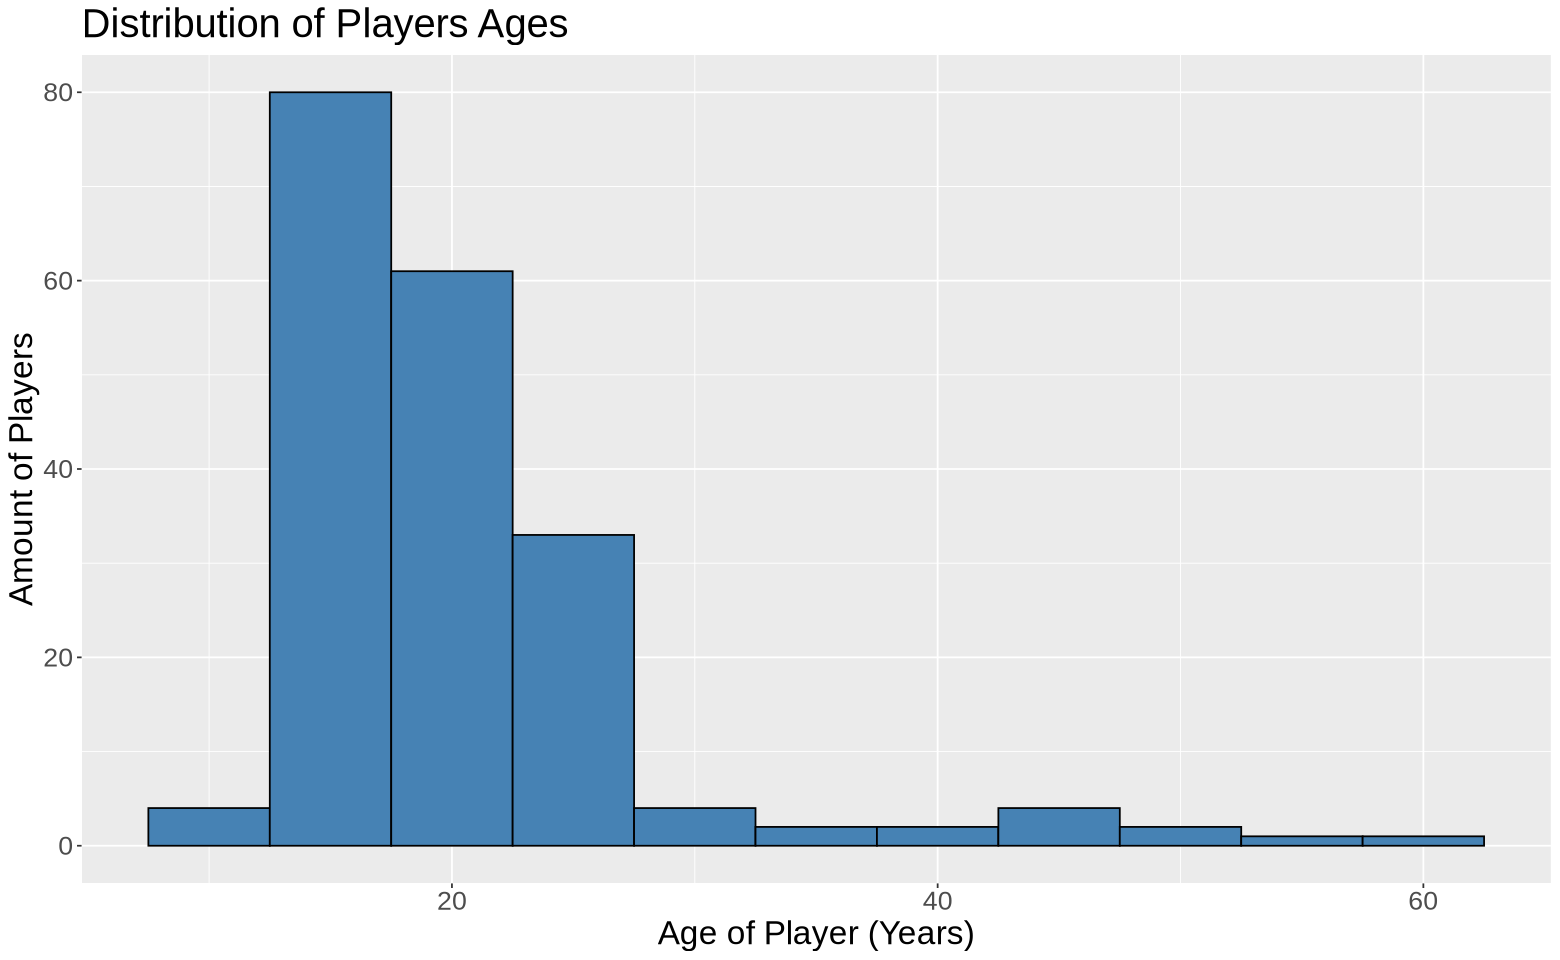

In [97]:
options(repr.plot.width = 13, repr.plot.height = 8)

dist_age_player <- player_data |>
    ggplot(aes(x = Age)) +
    geom_histogram(binwidth = 5, fill = "steelblue", color = "black") +
    labs(x = "Age of Player (Years)",
         y = "Amount of Players") +
    ggtitle("Distribution of Players Ages") +
    theme(text = element_text(size=20))

dist_age_player

Visualization 2: Distribution of Player Hours

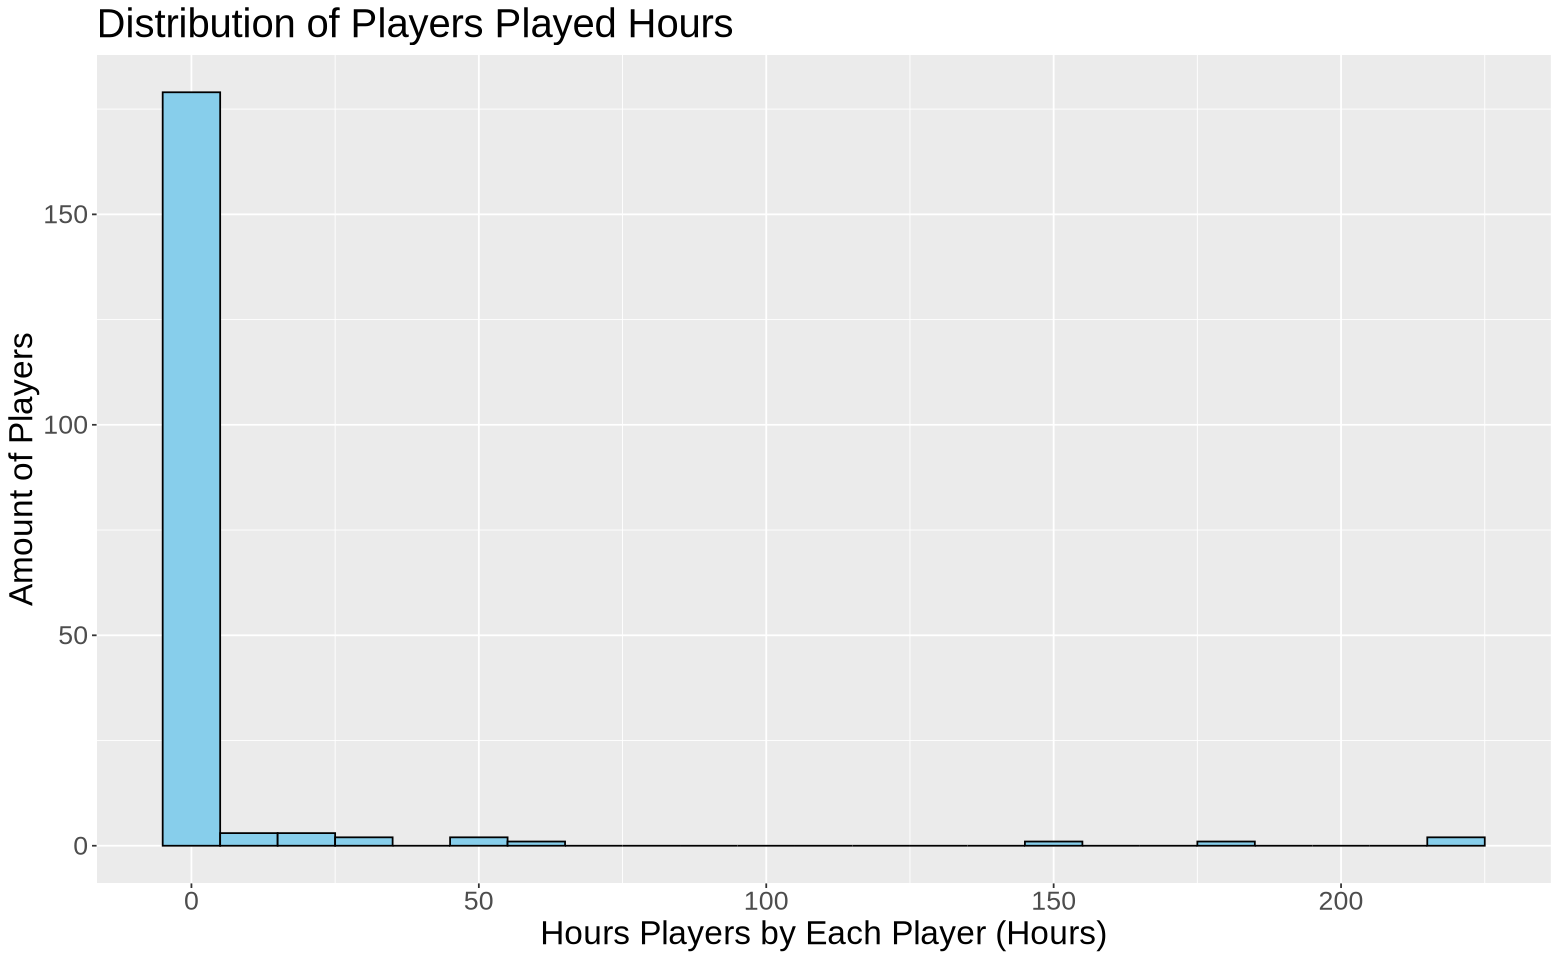

In [98]:
options(repr.plot.width = 13, repr.plot.height = 8)

dist_player_hours <- player_data |>
    ggplot(aes(x = played_hours)) +
    geom_histogram(binwidth = 10, fill = "skyblue", color = "black") +
    labs(x = "Hours Players by Each Player (Hours)",
         y = "Amount of Players") +
    ggtitle("Distribution of Players Played Hours") +
     theme(text = element_text(size=20))

dist_player_hours

Visualization 3: Player Age vs Hours Played vs Subscribed or Not

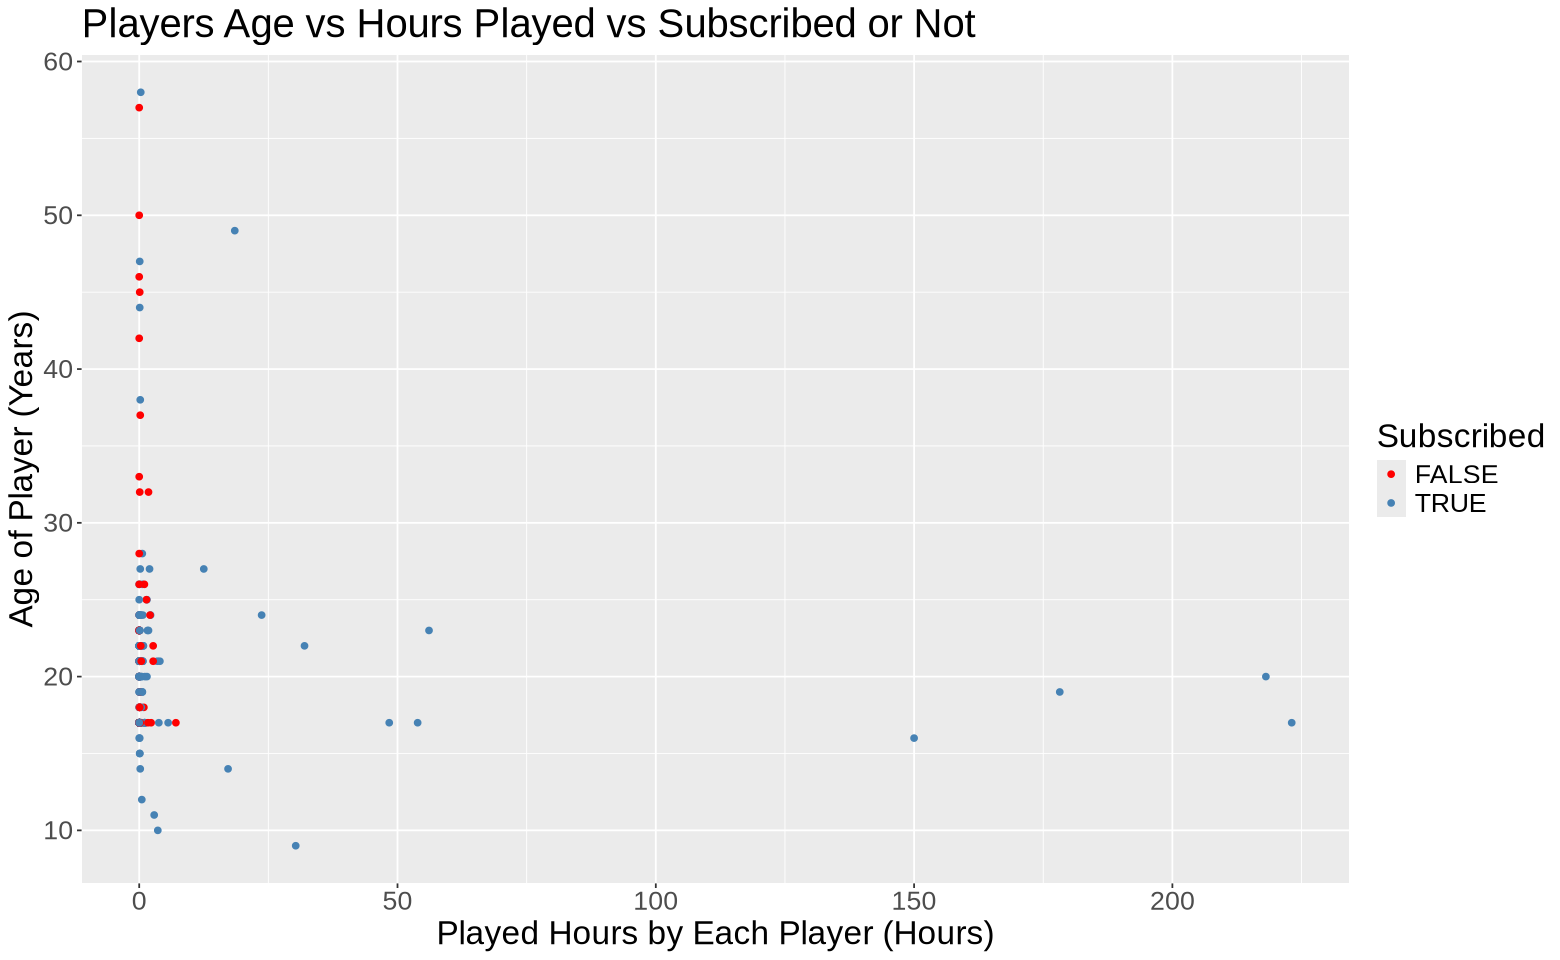

In [99]:
options(repr.plot.width = 13, repr.plot.height = 8)

played_hrs_vs_age <- player_data |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point(alpha = 1) +
    labs(x = "Played Hours by Each Player (Hours)",
         y = "Age of Player (Years)",
         color = "Subscribed") +
    ggtitle("Players Age vs Hours Played vs Subscribed or Not") +
    theme(text = element_text(size=20)) +
    scale_color_manual(values = c("TRUE" = "steelblue", "FALSE" = "red"))

played_hrs_vs_age

### Spliting data
To properly evaluate the performance of the model, the data is split into a training set and a testing set. The training set contains 75 percent of the observations, while the remaining 25 percent form the test set. Because the dataset is imbalanced, meaning there are significantly more subscribers than non-subscribers, the split is stratified by the subscription status to preserve the distribution of classes in both subsets. This ensures that the model sees a fair mix of both groups during training and testing, so it doesn’t accidentally learn to favour one over the other. To ensure the data split is reproducible across run and computers, we set a seed before performing the split.

In [100]:
set.seed(5)        
player_split <-initial_split(player_data, prop = 3/4, strata = subscribe)
player_train <- training(player_split)
player_test <- testing(player_split)

player_train

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,21
FALSE,0.0,22
FALSE,0.1,17
⋮,⋮,⋮
TRUE,0,17
TRUE,0,20
TRUE,0,17


### Recipe and standerdize of variables
We decided to use the k-nearest neighbours method, otherwise known as KNN, to predict the outcome for this scenario. Since KNN relies on distance calculations between observations, we need to make sure that the model is prepared and ready to be used. This “pre-processing” is a crucial step as it is done to ensure that both age and played hours contribute appropriately to the distance metric. 

Variables measured on different scales can distort distance calculations, so firstly we made sure the predictors are standardized through centering and scaling in the recipe. 

In [101]:
player_recipe <- recipe(subscribe ~ played_hours + Age, data = player_train)|>
                step_scale(all_predictors())|>
                step_center(all_predictors())

### Use cross validation decide K
The value of k is used to determine how many nearest neighbors are considered when predicting an observation’s class. Small values of K can lead to overfitting, where the model becomes too sensitive to noise in the training data. On the other hand, large values of K can generalize things too much and overlook the differences between the groups. The model is tuned using five-fold cross-validation on the training set.

To find the most appropiate K value for our model, we perform 5-fold cross-validations over a wide range of possible k-values, from 1 to 100. The mean accurcy of 5-fold cross-validation of each K value was collected, and K value with highest mean accuracy was chosen for our model.

A visualization of accuracy across all k-values reveals that accuracy fluctuates but gradually increases as k grows larger. The highest accuracy occurs at approximately K = 19; after this point the accuracy drops slightly and stabilizes after K = 23. This suggests that although there is considerable overlap between subscribers and non-subscribers, using a moderate number of neighbours allows the model to generalize reasonably well without being too sensitive to noise.


We used arrange() to arrange the accuracy from high to low, and sliced the first row with highest accuracy, which confirms to be K=19. 

In [102]:
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune())|>
            set_engine('kknn') |>
            set_mode('classification')

player_vfold <- vfold_cv(player_train, v = 5, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 1))

player_k_results <- workflow()|>
                    add_recipe(player_recipe)|>
                    add_model(knn_tune)|>
                    tune_grid(resamples = player_vfold, grid = k_vals)|>
                    collect_metrics()

In [103]:
player_k_accuracy <- player_k_results|>
                    filter(.metric == "accuracy")

player_k_best <- player_k_results|>
                    filter(.metric == "accuracy")|>
                    arrange(desc(mean))|>
                    slice(1)|>
                    pull(neighbors)

player_k_accuracy_plot <- ggplot(player_k_accuracy, aes(x=neighbors, y= mean)) +
                        geom_point()+
                        geom_line()+
                        xlab("K values (1-100)")+
                        ylab("Mean Accuracy")+
                        ggtitle("Mean Accuracy of 5-fold cross-validation for each K value")+
                        theme(text = element_text(size=20))


head(player_k_accuracy)
player_k_best

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4154187,5,0.05418303,Preprocessor1_Model001
2,accuracy,binary,0.4225616,5,0.05845039,Preprocessor1_Model002
3,accuracy,binary,0.5046470,5,0.03089173,Preprocessor1_Model003
4,accuracy,binary,0.5046470,5,0.03275981,Preprocessor1_Model004
5,accuracy,binary,0.5674548,5,0.04751351,Preprocessor1_Model005
6,accuracy,binary,0.5536617,5,0.04689939,Preprocessor1_Model006


[1] 19

Visulization 4: Mean Accuracy of 5-fold cross-validation for each K value

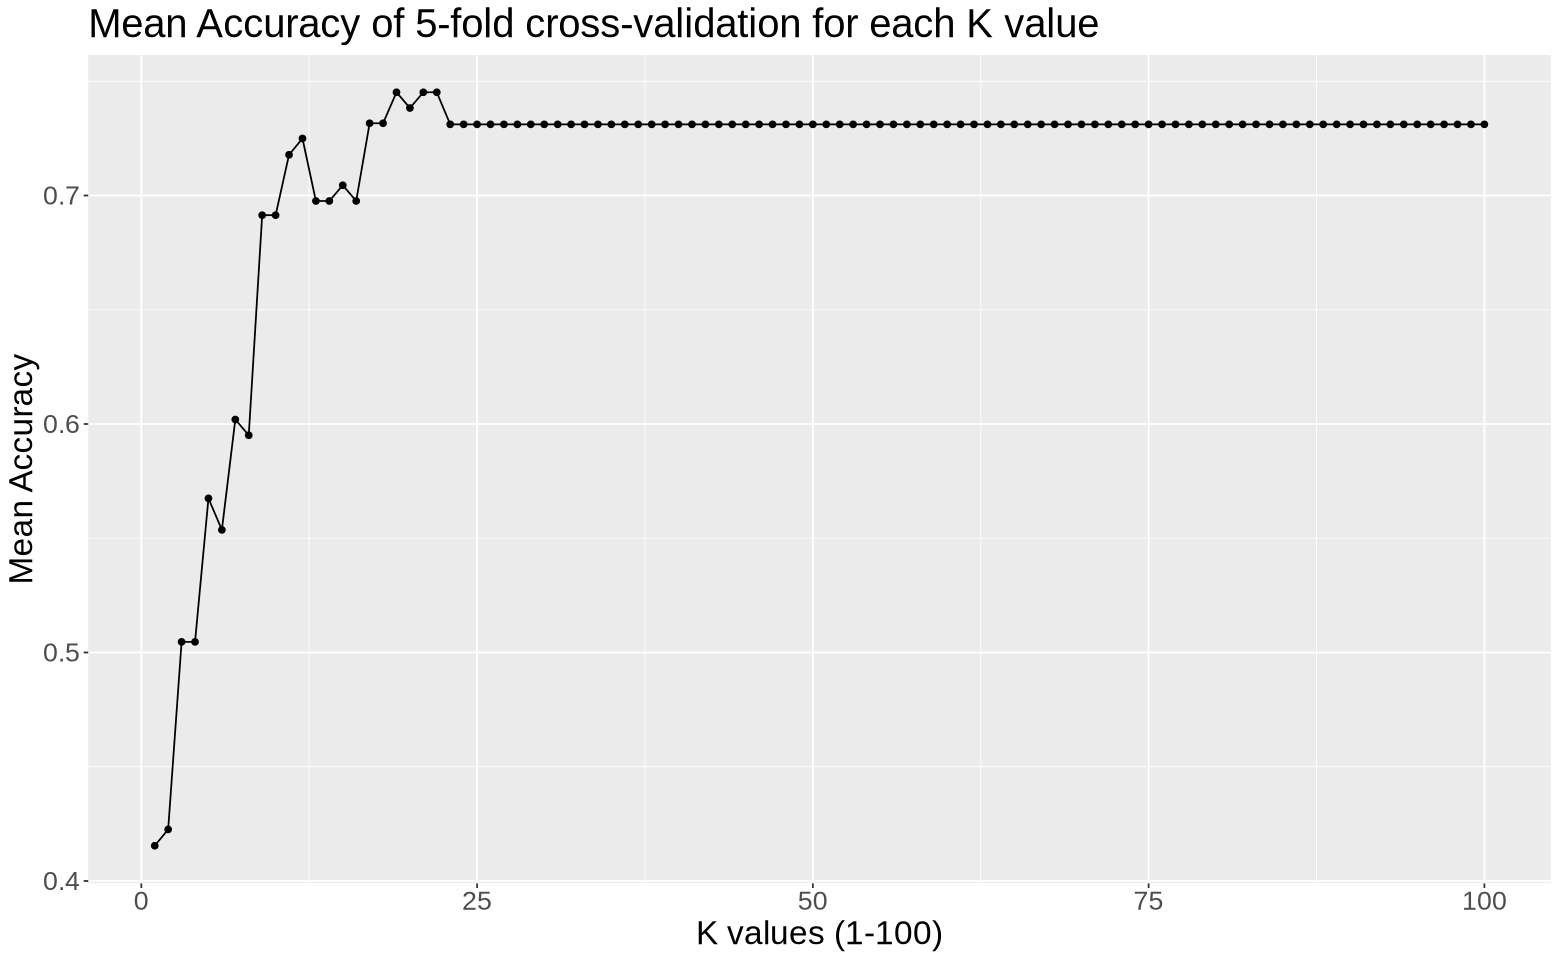

In [104]:
player_k_accuracy_plot

### Building Model with decided K value
Since K = 19 give highest mean accuracy in cross-validation, neighbor number = 19 is chosen to build our model. 

We build the model specificaiton with a number of neighbours fixed to 19. Then we created a workflow that combine the prr-processing recipe with the model specification, and the workflow was fitted using training data set.
Once training is complete, the model is applied to the test set to produce predictions. These predictions are compared to the true subscription labels in the test data, and accuracy is computed.

We also created a visulization of the model's predictions on the test data to better understand how it performs.

In [105]:
player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 19)|>
            set_engine('kknn') |>
            set_mode('classification')

player_fit <- workflow()|>
            add_recipe(player_recipe)|>
            add_model(player_spec)|>
            fit(data = player_train)

player_prediction <- predict(player_fit, player_test)|>
                    bind_cols(player_test)

player_prediction_accuracy <- player_prediction|>
                            metrics(truth = subscribe, estimate = .pred_class)
player_prediction_accuracy

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7755102
kap,binary,0.2606310


Visualization 5: KNN Classification Prediction Result on Test Data

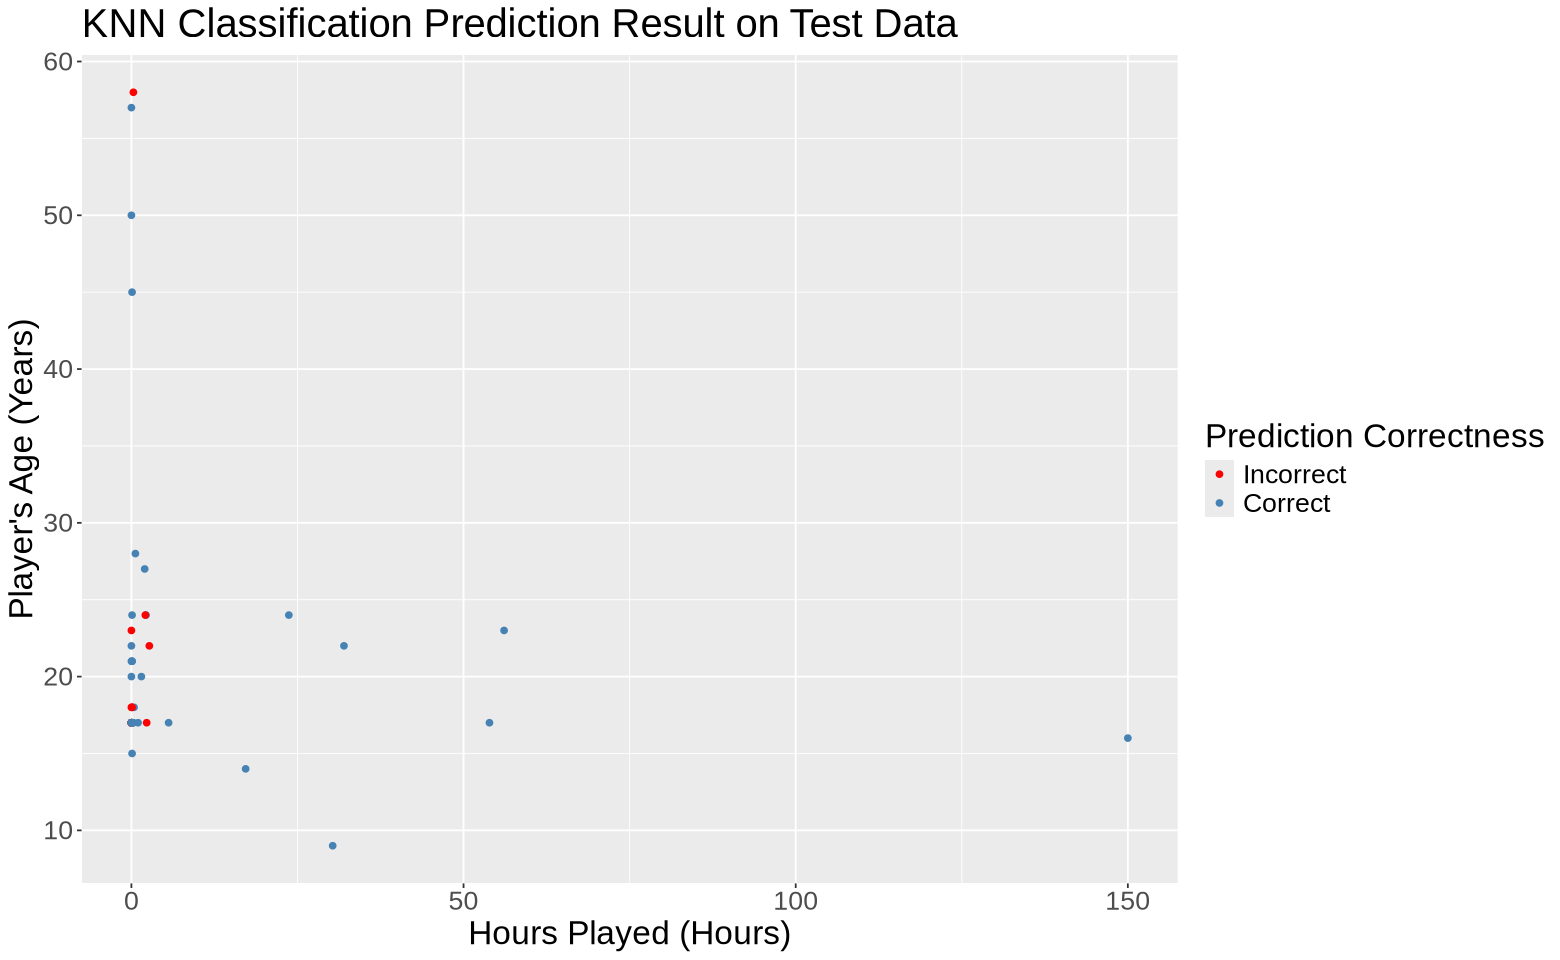

In [106]:
test_accuracy <- player_prediction |>
    mutate(correct = .pred_class == subscribe)

options(repr.plot.width = 13, repr.plot.height = 8)

test_accuracy_plot <- test_accuracy |>
    ggplot(aes(x = played_hours, y = Age, color = correct)) +
    geom_point() +
    scale_color_manual(values = c("red", "steelblue"),
                       labels = c("Incorrect", "Correct")) +
    labs(x = "Hours Played (Hours)",
         y = "Player's Age (Years)",
         color = "Prediction Correctness") +
    ggtitle("KNN Classification Prediction Result on Test Data") +
    theme(text = element_text(size=20))

test_accuracy_plot

## Discussion